In [6]:
from PIL import Image
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
selected_loadings = np.load('data/output/selected_loadings.npy')
selected_loadings.shape

(4, 332, 332)

In [8]:
component = 0

In [9]:
positive_m = np.where(selected_loadings[component,:,:]>0,selected_loadings[component,:,:],0)
positive_v = positive_m.sum(axis=1)
negative_m = np.where(selected_loadings[component,:,:]<0,selected_loadings[component,:,:],0)
negative_v = -1*negative_m.sum(axis=1)

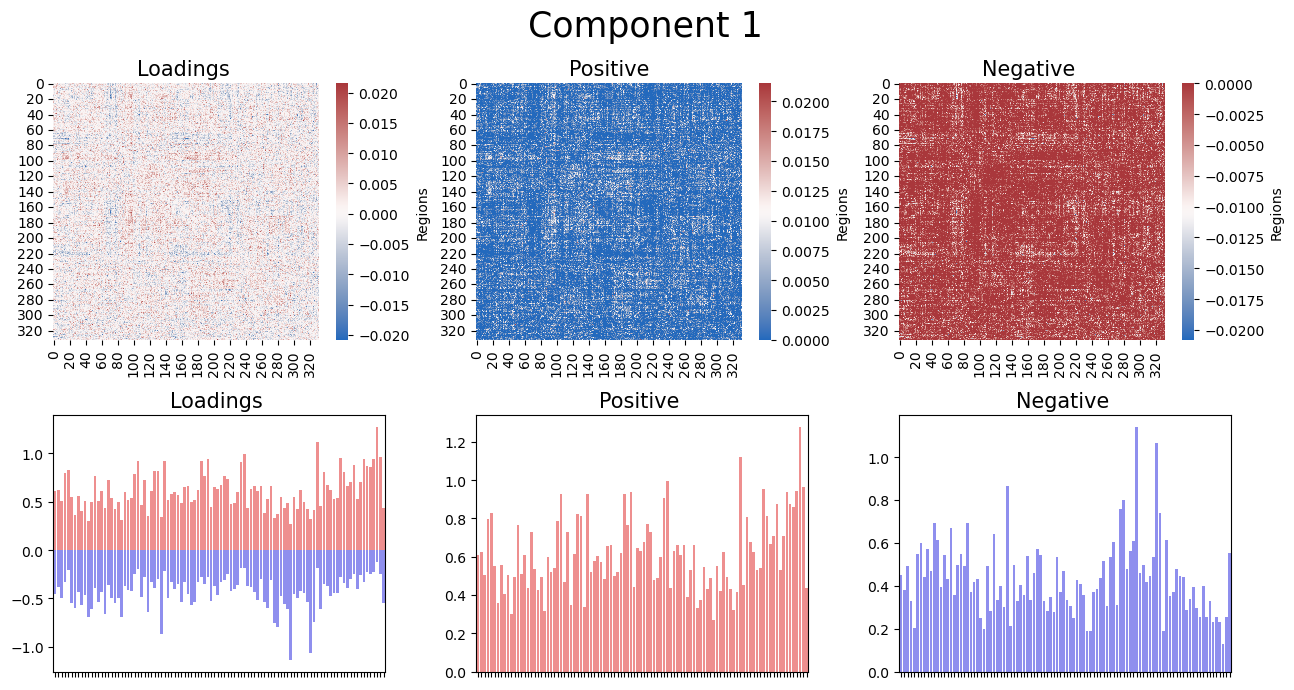

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(13, 7))
plt.suptitle(f'Component {component+1}', fontsize=25)

limit = 100

ax = axes[0][0]
ax.set_title(f'Loadings ', fontsize=15)
sns.heatmap(selected_loadings[component,:,:], cbar_kws={'label': 'Regions'}, cmap='vlag', ax=ax)

ax = axes[0][1]
ax.set_title(f'Positive', fontsize=15)
sns.heatmap(positive_m, cbar_kws={'label': 'Regions'}, cmap='vlag', ax=ax)

ax = axes[0][2]
ax.set_title(f'Negative ', fontsize=15)
sns.heatmap(negative_m, cbar_kws={'label': 'Regions'}, cmap='vlag', ax=ax)

ax = axes[1][0]
ax.set_title(f'Loadings ', fontsize=15)
sns.barplot(x=np.arange(limit), y=positive_v[:limit], color='red', alpha=0.5, ax=ax)
sns.barplot(x=np.arange(limit), y=(-1*negative_v[:limit]), color='blue', alpha=0.5, ax=ax)
ax.set_xticklabels([])

ax = axes[1][1]
ax.set_title(f'Positive ', fontsize=15)
sns.barplot(x=np.arange(limit), y=positive_v[:limit], color='red', alpha=0.5, ax=ax)
ax.set_xticklabels([])

ax = axes[1][2]
ax.set_title(f'Negative ', fontsize=15)
sns.barplot(x=np.arange(limit), y=negative_v[:limit], color='blue', alpha=0.5, ax=ax)
ax.set_xticklabels([])

plt.tight_layout()
plt.show()

In [11]:
networks_index = np.arange(332, dtype='float32')
networks_index[:6]

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [12]:
nii_file  = nib.load('data/input/brain_parcellation/brain_parcellation.nii.gz')
brain = nii_file.get_fdata()
print(type(brain))
print('Height, Channels, Width')
print(brain.shape)

<class 'numpy.ndarray'>
Height, Channels, Width
(208, 300, 320)


In [13]:
gray_mask = np.where(brain>0., 1., 0.)
gray_mask = np.array(gray_mask, dtype="float64")
np.unique(gray_mask)

array([0., 1.])

In [14]:
brain_binary = np.reshape(np.in1d(brain, networks_index),(208, 300, 320))
brain_filter = np.where(brain_binary!=0, brain, 0.)

In [15]:
n_components = 4

positive = []
negative = []

for c in range(n_components):
    positive_m = np.where(selected_loadings[c,:,:]>0, selected_loadings[c,:,:], 0)
    positive_v = positive_m.sum(axis=1)
    mapp_pos = dict(zip(networks_index, positive_v))
    
    negative_m = np.where(selected_loadings[c,:,:]<0, selected_loadings[c,:,:], 0)
    negative_v = -1*negative_m.sum(axis=1)
    mapp_neg = dict(zip(networks_index, negative_v))
    
    positive_mask = np.array(brain_filter)
    y = np.copy(positive_mask)
    for k, v in mapp_pos.items():
        positive_mask[y == k] = v
        
    positive.append(positive_mask)
    
    negative_mask = np.array(brain_filter)
    y = np.copy(negative_mask)
    for k, v in mapp_neg.items():
        negative_mask[y == k] = v
        
    negative.append(negative_mask)

In [16]:
positive_images = []
negative_images = []

positive_images_raw = []
negative_images_raw = []

for c in range(n_components):
    load_mask = positive[c]
    positive_output = gray_mask  + load_mask #####
    positive_images.append(positive_output)
    positive_images_raw.append(load_mask)
    
    load_mask = negative[c]
    negative_output = gray_mask  + load_mask #####
    negative_images.append(negative_output)
    negative_images_raw.append(load_mask)

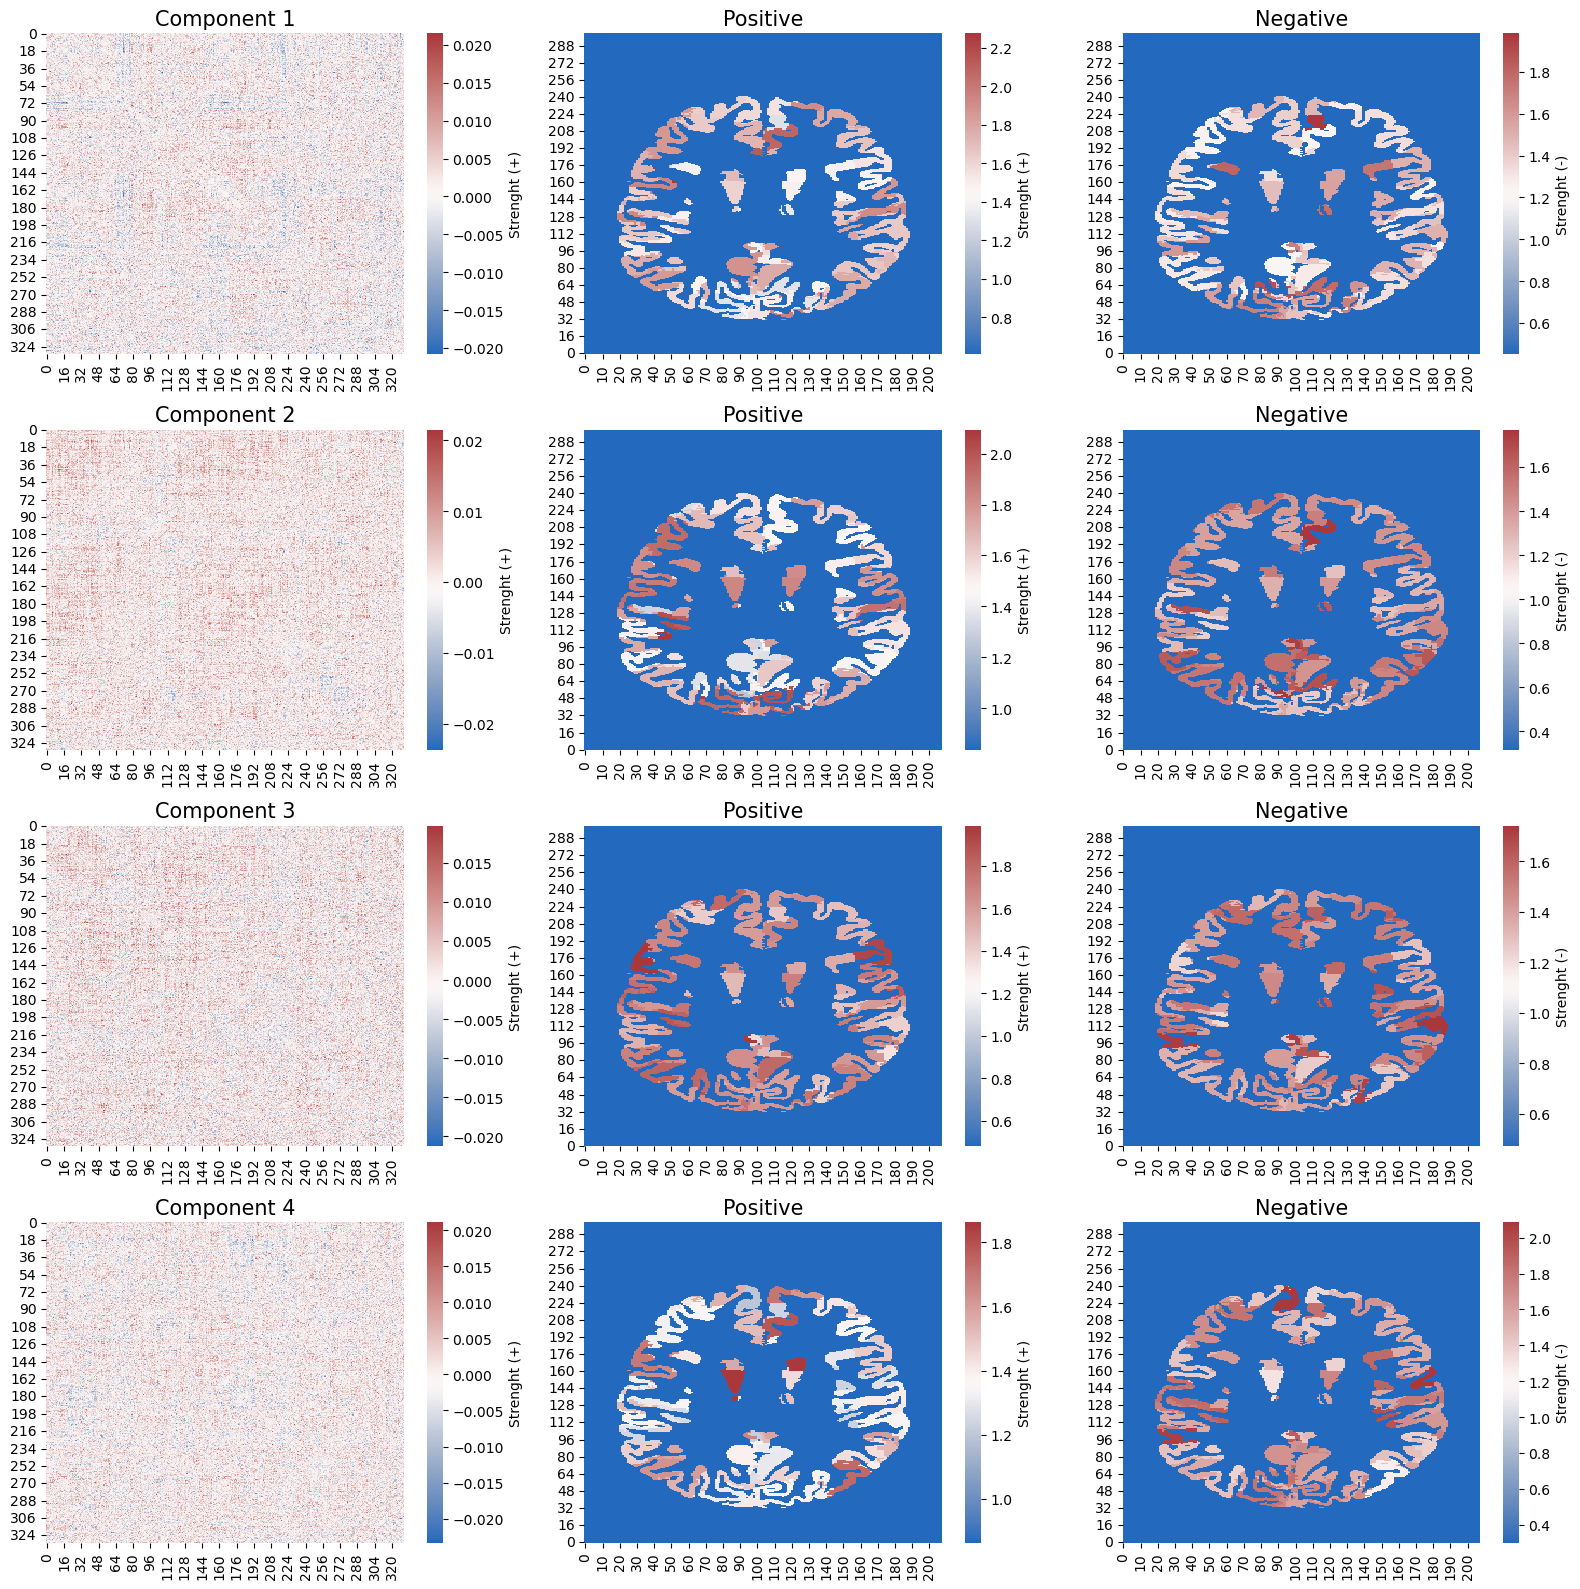

In [17]:
channel = 195

fig = plt.figure(figsize=(16, 16))
#fig.suptitle(f'Component {component+1}', fontsize=30)

n_rows = 4
n_cols = 3
for c in range(n_components):
    
    n_plot=(c+1) * n_cols

    ax = fig.add_subplot(n_rows, n_cols, n_plot-2)
    sns.heatmap(selected_loadings[c,:,:], cbar_kws={'label': 'Strenght (+)'}, cmap='vlag')
    plt.title(f'Component {c+1}', fontsize=15)
    
    ax = fig.add_subplot(n_rows, n_cols, n_plot-1)
    sns.heatmap(positive_images[c][:,:,channel].T, cbar_kws={'label': 'Strenght (+)'}, cmap='vlag')
    ax.invert_yaxis()
    plt.title(f'Positive', fontsize=15)
    
    ax = fig.add_subplot(n_rows, n_cols, n_plot)
    sns.heatmap(negative_images[c][:,:,channel].T, cbar_kws={'label': 'Strenght (-)'}, cmap='vlag')
    ax.invert_yaxis()
    plt.title(f'Negative', fontsize=15)

plt.tight_layout()

## Save NII Images

In [18]:
component = 0


img_pos = positive_images[c]

filename = f'data/output/nii_images/nii_component_{component+1}.nii.gz'
empty_header = nib.Nifti1Header()
img = nib.Nifti1Image(img_pos, nii_file.affine, empty_header)
nib.save(img, filename)